# Imports

In [1]:
%load_ext autoreload
%autoreload 2
from data import data_path
from images import images_path
from matplotlib.ticker import FormatStrFormatter
from utils.utils_workflow import plot_shapley_function, plot_shapley_value
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

# Some preprocessing

In [2]:
original_fig_size = [6.4, 4.8]
aspect_ratio =original_fig_size[0]/original_fig_size[1]
fig_size = [8 * aspect_ratio, 8]
shapley_polygonal_size = [10 * aspect_ratio, 10]

In [3]:
inupt_path = os.path.join(data_path, "input")
scenarios_file = os.path.join(inupt_path, "scenarios_all.csv")
scenarios_df = pd.read_csv(scenarios_file)
scenarios_df.head()

,scenario_id,type_covariate,type_transformation,eta,sample_size
0,1,fourier_expansion,linear_unimodal,0.05,200
1,2,fourier_expansion,linear_unimodal,0.05,500
2,3,fourier_expansion,linear_unimodal,0.25,200
3,4,fourier_expansion,linear_unimodal,0.25,500
4,5,fourier_expansion,linear_bimodal,0.05,200


In [4]:
main_keys = ["intervals", "middle_points"]
models = ["fnn", "knn", "lm"]
translation_dict = {
    "fnn": "FNN",
    "knn": "FKNN",
    "lm": "FLM",
    "mRMR_distance_correlation": "distance_corr",
    "mRMR_r2": "mRMR",
}

# Shapley value and $r^2$

### Gather the data

In [5]:
output_data_path = os.path.join(data_path, "output")
output_data_path_content = os.listdir(output_data_path)
scenarios = [x for x in output_data_path_content if 'scenario_' in  x]

In [6]:
# Decide whether to use the same number of simulations for all scenarios.
# If use_min_number_of_simulations is True, the minumum number of simulations will be used.
# Else if num_sim_to_use is not None, this number will be used
# Otherwise all scenarios use all the simulations computed
use_min_number_of_simulations = True
num_sim_to_use = None

In [7]:
# Count the number of simulations per scenario
simulations_data = {}
min_num_sim = np.Inf
# Iterate throughout all scenarios
for current_scenario_name in scenarios:
    simulations_data[current_scenario_name] = {}
    current_scenario_path = os.path.join(output_data_path, current_scenario_name)
    current_scenario_path_content = os.listdir(current_scenario_path)
    shapley_files = [x for x in current_scenario_path_content if 'shapley_' in  x]
    simulations_identifiers = [x[8:-4] for x in shapley_files]
    num_simulations_current_sc = len(shapley_files)
    simulations_data[current_scenario_name]["num_simulations"] = num_simulations_current_sc
    simulations_data[current_scenario_name]["simulations_ids"] = simulations_identifiers
    if num_simulations_current_sc < min_num_sim:
        min_num_sim = num_simulations_current_sc

In [8]:
print(min_num_sim)

100


In [9]:
for current_scenario_name in simulations_data.keys():
    simulations_identifiers = simulations_data[current_scenario_name]["simulations_ids"]
    sim_to_select = len(simulations_identifiers)
    if use_min_number_of_simulations:
        sim_to_select = min_num_sim
    elif not num_sim_to_use is None:
        sim_to_select = num_sim_to_use
    np.random.seed(1234)
    selected_sample = np.random.choice(
        a=simulations_identifiers,
        size=sim_to_select,
        replace=False
    )
    simulations_data[current_scenario_name]["selected_simulations_ids"] = list(selected_sample)

In [10]:
run_sanity_check = False
# Sanity check
if run_sanity_check:
    for current_scenario_name in simulations_data.keys():
        print(current_scenario_name)
        if (use_min_number_of_simulations) or not (num_sim_to_use is None):
            print(len(simulations_data[current_scenario_name]["selected_simulations_ids"]))
        else:
            print(len(simulations_data[current_scenario_name]["selected_simulations_ids"]) - simulations_data[current_scenario_name]["num_simulations"])    

In [11]:
with open("number_simulations.txt", "w") as f:
    for i_sim in range(1, 61):
        key = f"scenario_{i_sim}"
        num_s = simulations_data[key]["num_simulations"]
        sel_sim = len(simulations_data[key]["selected_simulations_ids"])
        str_line = f"{key} -> total simulations: {num_s}, selected simulations: {sel_sim}\n"
        f.write(str_line)

In [12]:
# Obtain the data as a dictionary
results_shapley_dict = {}
results_r2_dict = {}
results_distance_corr = {}
results_correlation_coeff = {}
# Iterate throughout all scenarios
for current_scenario_name in scenarios:
#for current_scenario_name in ["scenario_1"]:
    current_scenario_path = os.path.join(output_data_path, current_scenario_name)
    selected_simulations_ids = simulations_data[current_scenario_name]["selected_simulations_ids"]
    shapley_files = [
        f"shapley_{sim}.pkl" for sim in selected_simulations_ids
    ]
    # Iterate throughout all Shapley files
    for current_shapley_name in shapley_files:
        max_val = -np.inf
        current_shapley_file = os.path.join(current_scenario_path, current_shapley_name)
        with open(current_shapley_file, "rb") as file:
            data = pickle.load(file)
        data_keys = data.keys()
        if current_scenario_name in results_shapley_dict.keys():
            #print(current_scenario_name, "key fould")
            for k in data_keys:
                current_data = np.array(data[k])
                if not k in main_keys:
                    current_data_floor = np.maximum(current_data, 0)
                    if k == "mRMR_distance_correlation":
                        sum_values = np.sum(current_data_floor)
                        current_data_floor = np.multiply(
                            current_data_floor,
                            sum_values
                        )
                    max_current_data_floor = np.max(current_data_floor)
                    results_shapley_dict[current_scenario_name][k] = np.row_stack(
                        (
                            results_shapley_dict[current_scenario_name][k],
                            current_data_floor
                        )
                    )
                    if k == "mRMR_distance_correlation":
                        results_distance_corr[current_scenario_name] = np.row_stack(
                            (
                                results_distance_corr[current_scenario_name],
                                current_data_floor
                            )
                        )
                    if k == "mRMR_r2":
                        results_correlation_coeff[current_scenario_name] = np.row_stack(
                            (
                                results_correlation_coeff[current_scenario_name],
                                current_data_floor
                            )
                        )
                    if k != "mRMR_r2" and max_current_data_floor > max_val:
                        #print(k, max_current_data_floor)
                        max_val = max_current_data_floor
            results_mrmr_r2 = results_shapley_dict[current_scenario_name]["mRMR_r2"][-1]
            results_shapley_dict[current_scenario_name]["mRMR_r2"][-1] = np.multiply(
                results_mrmr_r2,
                max_val/np.max(results_mrmr_r2)
            )
        else:
            #print(current_scenario_name, "key not fould")
            results_shapley_dict[current_scenario_name] = {}
            for k in data_keys:
                current_data = np.array(data[k])
                if k in main_keys:
                    results_shapley_dict[current_scenario_name][k] = current_data
                else:
                    current_data_floor = np.maximum(current_data, 0)
                    if k == "mRMR_distance_correlation":
                        sum_values = np.sum(current_data_floor)
                        current_data_floor = np.multiply(
                            current_data_floor,
                            sum_values,
                        )
                    max_current_data_floor = np.max(current_data_floor)
                    results_shapley_dict[current_scenario_name][k] = current_data_floor
                    if k == "mRMR_distance_correlation":
                        results_distance_corr[current_scenario_name] = current_data_floor
                    if k == "mRMR_r2":
                        results_correlation_coeff[current_scenario_name] = current_data_floor
                    if k != "mRMR_r2" and max_current_data_floor > max_val:
                        #print(k, max_current_data_floor)
                        max_val = max_current_data_floor
            results_mrmr_r2 = results_shapley_dict[current_scenario_name]["mRMR_r2"]
            results_shapley_dict[current_scenario_name]["mRMR_r2"] = np.multiply(
                results_mrmr_r2,
                max_val/np.max(results_mrmr_r2)
            )
    # Iterate throughout all r2 files
    for current_model in models:
        current_r2_model_files = [
            f"r2_test_{current_model}_{sim}.pkl" for sim in selected_simulations_ids
        ]
        new_key = translation_dict[current_model]
        for current_r2_model_name in current_r2_model_files:
            current_r2_file = os.path.join(current_scenario_path, current_r2_model_name)
            with open(current_r2_file, "rb") as file:
                r2_data = pickle.load(file)
            if current_scenario_name in results_r2_dict.keys():
                if new_key in results_r2_dict[current_scenario_name].keys():
                    results_r2_dict[current_scenario_name][new_key].append(r2_data)
                else:
                    results_r2_dict[current_scenario_name][new_key] = [r2_data]
            else:
                results_r2_dict[current_scenario_name] = {}
                results_r2_dict[current_scenario_name][new_key] = [r2_data]

### Compute aggregated statistics for the Shapley value

In [13]:
aggregated_shapley_dict = {}
results_shapley_dict_keys = results_shapley_dict.keys()
for sc in results_shapley_dict_keys:
    aggregated_shapley_dict[sc] = {}
    current_data = results_shapley_dict[sc]
    current_data_keys = current_data.keys()
    for key in current_data_keys:
        if key in main_keys:
            aggregated_shapley_dict[sc][key] = current_data[key]
        else:
            aggregated_shapley_dict[sc][key] = list(np.mean(current_data[key], axis=0))

### Compute aggregated statistics for $r^2$

In [14]:
scenarios_names = list(results_r2_dict.keys())
scenarios_sim = [int(x[9:]) for x in scenarios_names]
models_computed = list(results_r2_dict[scenarios_names[0]].keys())
stats_to_apply = {
    "mean" : np.mean,
    "std" : np.std
}
stats_to_apply_keys = stats_to_apply.keys()
X_r2 = np.full(
    shape=(len(scenarios_names), 2*len(models_computed)),
    fill_value=np.nan
)

i_row = 0
number_sim = []
for sc in scenarios_names:
    current_data_sc = results_r2_dict[sc]
    current_stats = []
    for model in models_computed:
        current_data_model = current_data_sc[model]
        number_sim.append(len(current_data_model))
        for k in stats_to_apply_keys:
            fun = stats_to_apply[k]
            val = fun(current_data_model)
            current_stats.append(val)
    X_r2[i_row] = current_stats
    i_row += 1

In [15]:
print(np.min(number_sim), np.max(number_sim))

100 100


In [16]:
col_names = []
for model in models_computed:
    for st in stats_to_apply_keys:
        col_names.append(f"{model}_{st}")
df_r2 = pd.DataFrame(
    data=X_r2,
    columns=col_names,
    index=scenarios_names,
)
df_r2["sim"] = scenarios_sim
df_r2.sort_values(by="sim", inplace=True)
df_r2.head()

,FNN_mean,FNN_std,FKNN_mean,FKNN_std,FLM_mean,FLM_std,sim
scenario_1,0.888671,0.081237,0.539934,0.039190,0.946768,0.005398,1
scenario_2,0.928055,0.057306,0.604361,0.027418,0.948764,0.003422,2
scenario_3,0.693648,0.056964,0.398740,0.041165,0.731684,0.028210,3
scenario_4,0.724672,0.051330,0.458090,0.022135,0.743208,0.018000,4
scenario_5,0.863417,0.072580,0.537678,0.036970,0.946359,0.006158,5


### Compute aggregated statistics for distance correlation

In [17]:
stats_to_apply_keys = stats_to_apply.keys()
X_r2_distance_corr = np.full(
    shape=(len(scenarios_names), 2),
    fill_value=np.nan
)

i_row = 0
number_sim = []
for sc in scenarios_names:
    current_stats = []
    cummulative_distance_corr = np.sum(results_distance_corr[sc], axis=1)
    for k in stats_to_apply_keys:
        fun = stats_to_apply[k]
        val = fun(cummulative_distance_corr)
        current_stats.append(val)
    X_r2_distance_corr[i_row] = current_stats
    i_row += 1

In [18]:
col_names = []
key_for_distance_correlation = translation_dict["mRMR_distance_correlation"]
for k in stats_to_apply.keys():
    col_names.append(f"{key_for_distance_correlation}_{k}")
df_distance_corr = pd.DataFrame(
    data=X_r2_distance_corr,
    columns=col_names,
    index=scenarios_names,
)
df_distance_corr["sim"] = scenarios_sim
df_distance_corr.sort_values(by="sim", inplace=True)
df_distance_corr.head()

,distance_corr_mean,distance_corr_std,sim
scenario_1,0.234575,0.017557,1
scenario_2,0.256436,0.035967,2
scenario_3,0.191341,0.015393,3
scenario_4,0.187416,0.012467,4
scenario_5,0.229060,0.018401,5


### Compute aggregated statistics for correlation coefficient

In [19]:
stats_to_apply_keys = stats_to_apply.keys()
X_r2_correlation_coeff = np.full(
    shape=(len(scenarios_names), 2),
    fill_value=np.nan
)

i_row = 0
number_sim = []
for sc in scenarios_names:
    current_stats = []
    cummulative_correlation_coeff = np.sum(results_correlation_coeff[sc], axis=1)
    for k in stats_to_apply_keys:
        fun = stats_to_apply[k]
        val = fun(cummulative_correlation_coeff)
        current_stats.append(val)
    X_r2_correlation_coeff[i_row] = current_stats
    i_row += 1

In [20]:
col_names = []
key_for_correlation_coeff = translation_dict["mRMR_r2"]
for k in stats_to_apply.keys():
    col_names.append(f"{key_for_correlation_coeff}_{k}")
df_correlation_coeff = pd.DataFrame(
    data=X_r2_correlation_coeff,
    columns=col_names,
    index=scenarios_names,
)
df_correlation_coeff["sim"] = scenarios_sim
df_correlation_coeff.sort_values(by="sim", inplace=True)
df_correlation_coeff.head()

,mRMR_mean,mRMR_std,sim
scenario_1,1.142526,0.065224,1
scenario_2,1.153317,0.076267,2
scenario_3,1.054376,0.074761,3
scenario_4,1.031436,0.043005,4
scenario_5,1.342749,0.073404,5


# Join all the info regarding $r^2$

In [21]:
scenarios_df_reindex = scenarios_df.set_index("scenario_id")
df_r2_reindex = df_r2.set_index("sim")
df_distance_corr_reindex = df_distance_corr.set_index("sim")
df_correlation_coeff_reindex = df_correlation_coeff.set_index("sim")
df_r2_results = scenarios_df_reindex.join(df_r2_reindex).join(df_distance_corr_reindex).join(df_correlation_coeff_reindex)

In [22]:
df_r2_results.head(10)

,type_covariate,type_transformation,eta,sample_size,FNN_mean,FNN_std,FKNN_mean,FKNN_std,FLM_mean,FLM_std,distance_corr_mean,distance_corr_std,mRMR_mean,mRMR_std
scenario_id,,,,,,,,,,,,,,
1,fourier_expansion,linear_unimodal,0.05,200,0.888671,0.081237,0.539934,0.039190,0.946768,0.005398,0.234575,0.017557,1.142526,0.065224
2,fourier_expansion,linear_unimodal,0.05,500,0.928055,0.057306,0.604361,0.027418,0.948764,0.003422,0.256436,0.035967,1.153317,0.076267
3,fourier_expansion,linear_unimodal,0.25,200,0.693648,0.056964,0.398740,0.041165,0.731684,0.028210,0.191341,0.015393,1.054376,0.074761
4,fourier_expansion,linear_unimodal,0.25,500,0.724672,0.051330,0.458090,0.022135,0.743208,0.018000,0.187416,0.012467,1.031436,0.043005
5,fourier_expansion,linear_bimodal,0.05,200,0.863417,0.072580,0.537678,0.036970,0.946359,0.006158,0.229060,0.018401,1.342749,0.073404
6,fourier_expansion,linear_bimodal,0.05,500,0.896299,0.091714,0.604633,0.020266,0.948560,0.003144,0.248430,0.028364,1.407653,0.077145
7,fourier_expansion,linear_bimodal,0.25,200,0.654205,0.071994,0.399486,0.039844,0.731468,0.027795,0.187650,0.013758,1.221481,0.074737
8,fourier_expansion,linear_bimodal,0.25,500,0.697895,0.063745,0.461300,0.025181,0.741472,0.018525,0.183911,0.013359,1.257244,0.053093
9,fourier_expansion,non_linear_unimodal,0.05,200,0.336131,0.144991,0.048966,0.080440,-0.028925,0.033138,0.092482,0.006675,0.542551,0.068400


In [23]:
df_r2_results.to_csv(os.path.join(data_path, "other", "r2_models.csv"))

# Plots

### Plots for the Shapley value

In [24]:
aggregated_shapley_dict_keys = list(aggregated_shapley_dict.keys())
for scenario in aggregated_shapley_dict_keys:
    current_scenario_id_int = int(scenario[9:])
    current_scenario_id_str = str(current_scenario_id_int)
    current_scenario_id_str = current_scenario_id_str.zfill(2)
    val = aggregated_shapley_dict[scenario]
    current_scenario_info = scenarios_df[scenarios_df["scenario_id"] == current_scenario_id_int]
    current_eta = str(current_scenario_info.eta.squeeze()).replace(".", "")
    current_type_covariate = current_scenario_info.type_covariate.squeeze()
    current_type_transformation = current_scenario_info.type_transformation.squeeze()
    current_sample_size = current_scenario_info.sample_size.squeeze()
    file_name = f"{current_scenario_id_str}__{current_type_covariate}__{current_type_transformation}__{current_sample_size}__{current_eta}.pdf"
    fig, ax = plt.subplots(1)
    fig.set_size_inches(6.4, 4.8)
    fig_siz1, fig_siz2 = fig.get_size_inches()
    ax.tick_params(axis='x', labelsize=28)
    ax.tick_params(axis='y', labelsize=28)
    ax.set_xlabel(r"$t$", fontsize=30)
    ax.set_ylabel(r"$\mathcal{R}(t)$", fontsize=30)
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if current_type_covariate == "fourier_expansion":
        ax.yaxis.label.set_color('black')
    if current_type_transformation == "linear_discrete":
        ax.xaxis.label.set_color('black')
    lgd = plot_shapley_value(
        obj=val,
        domain_range=(0, 1),
        translation_dict=translation_dict,
        display_legend=False,
        disregard_feature_selection=True,
    )
    ax.set_facecolor("white")
    fig.set_facecolor("none")
    fig.set_size_inches(shapley_polygonal_size)
    fig.savefig(os.path.join(images_path, file_name), format="pdf")
    plt.close()

In [25]:
aggregated_shapley_dict_keys = list(aggregated_shapley_dict.keys())
for scenario in aggregated_shapley_dict_keys:
    current_scenario_id_int = int(scenario[9:])
    current_scenario_id_str = str(current_scenario_id_int)
    current_scenario_id_str = current_scenario_id_str.zfill(2)
    val = aggregated_shapley_dict[scenario]
    current_scenario_info = scenarios_df[scenarios_df["scenario_id"] == current_scenario_id_int]
    current_eta = str(current_scenario_info.eta.squeeze()).replace(".", "")
    current_type_covariate = current_scenario_info.type_covariate.squeeze()
    current_type_transformation = current_scenario_info.type_transformation.squeeze()
    current_sample_size = current_scenario_info.sample_size.squeeze()
    file_name = f"step_{current_scenario_id_str}__{current_type_covariate}__{current_type_transformation}__{current_sample_size}__{current_eta}.pdf"
    fig, ax = plt.subplots(1)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    if current_type_covariate == "brownian_trend":
        ax.set_xlabel(r"$t$", fontsize=22)
    if current_type_transformation == "linear_unimodal":
        ax.set_ylabel(r"$\mathcal{R}_f(t)$", fontsize=22)
    plot_shapley_function(
        obj=val,
        domain_range=(0, 1),
        translation_dict=translation_dict,
        disregard_feature_selection=True,
    )
    ax.set_facecolor("white")
    fig.set_facecolor("none")
    plt.savefig(os.path.join(images_path, file_name), format="pdf")
    plt.close()

# Misc

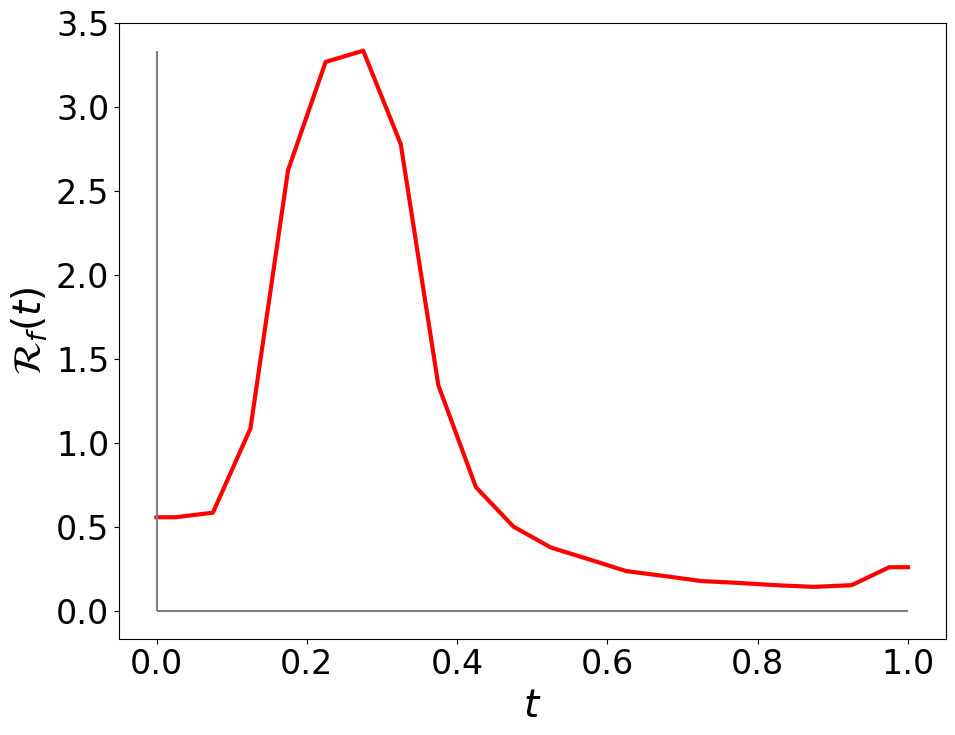

In [26]:
keys_to_consider = ['intervals', 'middle_points', 'lm']
val = aggregated_shapley_dict["scenario_1"]
single_scenario = {k: val[k] for k in keys_to_consider}
fig, ax =  plt.subplots(1)
plot_shapley_value(
    obj=single_scenario,
    domain_range=(0, 1),
    display_legend=False,
    translation_dict=translation_dict,
)
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)
ax.set_xlabel(r"$t$", fontsize=28)
ax.set_ylabel(r"$\mathcal{R}_f(t)$", fontsize=28)
fig.set_size_inches(fig_size)
fig.savefig(os.path.join(images_path, "shapley_relevance_single_scenario.pdf"), format="pdf")
    

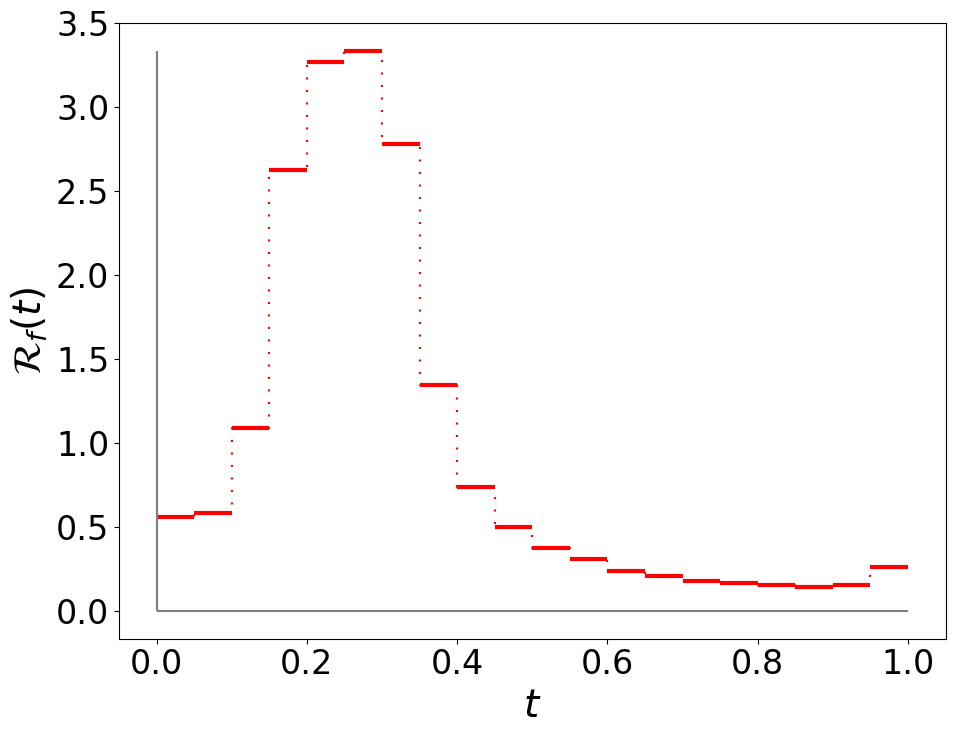

In [27]:
fig, ax =  plt.subplots(1)
plot_shapley_function(
    obj=single_scenario,
    domain_range=(0, 1),
    plot_h_line=True,
    plot_v_line=True,
    display_legend=False,
    translation_dict=translation_dict,
)
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)
ax.set_xlabel(r"$t$", fontsize=28)
ax.set_ylabel(r"$\mathcal{R}_f(t)$", fontsize=28)
fig.set_size_inches(fig_size)
fig.savefig(os.path.join(images_path, "shapley_step_single_scenario.pdf"), format="pdf")

# Legend

['FLM', 'FKNN', 'FNN']


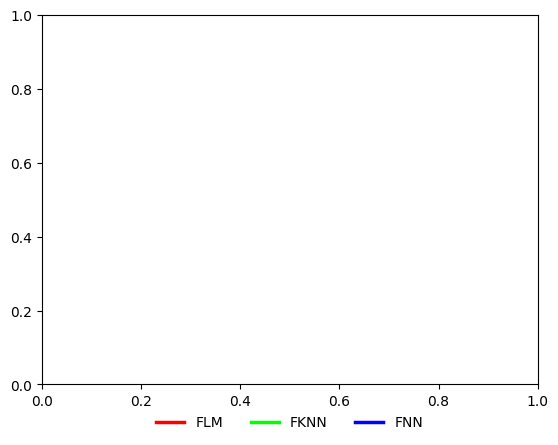

In [28]:
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
colors_code = np.array([
    [255, 0, 0],
    [0, 255, 0],
    [0, 0, 255],
    [0, 0, 0],
    [218, 112, 214],
    [107, 223, 205],
    [128, 128, 128]
])/255
cmap = ListedColormap(colors_code)
colors = cmap.colors
function_names = [
    translation_dict[x] for x in aggregated_shapley_dict["scenario_1"].keys() if x not in main_keys and x not in ["mRMR_r2", "mRMR_distance_correlation"]
]
print(function_names)
leg = plt.legend(
    handles=[Line2D([], [], color=col, lw=2.5) for col in colors],
    labels=function_names,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),
    fancybox=True,
    shadow=True,
    frameon=False,
    ncol=len(function_names),
)

In [29]:
fig  = leg.figure
fig.canvas.draw()
bbox  = leg.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig(os.path.join(images_path, "legend.pdf"), dpi="figure", bbox_inches=bbox, format="pdf")